In [1]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [12]:
# data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [13]:
data.head()

TV_ANE  TV_AMC  TV_ANIMALPLANET  TV_BBCAMERICA  TV_BET  TV_BETHER  \
0     0.0     0.0              0.0            0.0     0.0        0.0   
1     0.0     0.0              2.0            0.0     0.0        0.0   
2     0.0     0.0              0.0            0.0     0.0        0.0   
3     0.0     0.0              0.0            0.0     0.0        0.0   
4     0.0     2.0              0.0            0.0     0.0        0.0   

   TV_BRAVO  TV_COMEDYCENTRAL  TV_COUNTRYMUSICTELEVISION  TV_FOODNETWORK  ...  \
0       0.0               0.0                        0.0             0.0  ...   
1       0.0               0.0                        0.0             0.0  ...   
2       0.0               0.0                        0.0             0.0  ...   
3       0.0               0.0                        2.0             0.0  ...   
4       0.0               0.0                        0.0             0.0  ...   

   TV_SMITHSONIANNETWORK  TV_SYFY  TV_TRUTV  TV_TVONE  TV_USANETWORK  TV_VH1  \
0                    0.0      0.0       0.0       0.0            0.0     0.0   
1                    0.0      0.0       0.0       0.0            0.0     0.0   
2                    0.0      0.0       0.0       0.0            0.0     0.0   
3                    0.0      0.0       0.0       0.0            1.0     0.0   
4                    0.0      0.0       0.0       0.0            0.0     0.0   

   TV_WETV  DIGITAL_HX  DIGITAL_TREMOR  TOTAL_CONV  
0      0.0        1.39             0.0          16  
1      0.0        1.00             0.0           0  
2      0.0       13.00             0.0           0  
3      0.0        0.00             0.0           0  
4      0.0        0.00             0.0           0  

[5 rows x 30 columns]

In [14]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

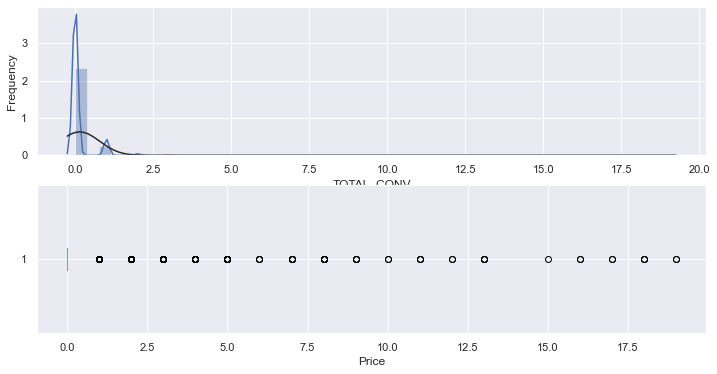

In [15]:
target_distribution(data.TOTAL_CONV)

In [106]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [386]:
# Scaling all data with MinMaxScaler
# scaller = MinMaxScaler()
# data= pd.DataFrame(scaller.fit_transform(data), columns= data.columns)

In [17]:
# with pm.Model() as model_gamma:
    
#     # Intercept
#     alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
    
#     # Slope
#     beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))
    
#     # Error term
#     eps = pm.HalfCauchy('eps', 5)
    
#     #v_ = pm.Exponential('v_', 1/29)
#     #v = pm.Deterministic('v', v_+1)
    
#     # Expected value of outcome (ML Regression with vectors)
#     mu = alpha + pm.math.dot(x, beta)
    
#     # Likelihood
#     conversion = pm.Gamma('conversion', mu= mu, sigma= eps, observed=y)
    
#     # posterior
#     trace_gamma = pm.sample(chains = 4)

In [18]:
# az.summary(trace_gamma,
#            var_names = 'beta'
#           ).set_index(data[[col for col in data.columns if col != 'TOTAL_CONV']].columns)

In [19]:
# ppc_gamma = pm.sample_posterior_predictive(trace_gamma, samples=200, model=model_gamma)

In [20]:
# az.r2_score(data.TOTAL_CONV.values, ppc_gamma['conversion'])

In [21]:
# data_ppc_gamma = az.from_pymc3(trace= trace_gamma, posterior_predictive= ppc_gamma)
# ax = az.plot_ppc(data_ppc_gamma, figsize=(8,4), mean= True, color='C3',)
# ax.legend(fontsize= 13)
# ax.set_xlabel('TOTAL_CONV')
# plt.show()

### Priors for GLM module

In [296]:
# # Formula for Bayesian Multiple Linear Regression
# formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

# # constructing priors:
# d_coef = {}
# for val in data.columns[:-1]:
#     d_coef[val] = d_coef.get(val, pm.HalfFlat.dist())
    
# # defining intercept destribution
# d_intercept = {'Intercept': pm.Normal.dist(mu=0, sd=100)}

# # combining priors
# d_priors = {**d_intercept,**d_coef}

### ZeroInflatedNegativeBinomial as Likelihood

In [26]:
psi_values =[round(v,2) for v in np.arange(0.1,1,0.1).tolist()]

In [28]:
individual_traces = {}
individual_models = {}

for i,psi in enumerate(psi_values) :
    with pm.Model() as model:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)

        # Likelihood
        conversion = pm.ZeroInflatedPoisson('conversion', theta= mu, psi= psi,  observed=y)

        # posterior
        individual_trace = pm.sample(chains = 4, target_accept = 0.9)
    
    individual_models['model_'+str(i+1)] = model
    individual_traces['trace_psi_'+str(psi)] = individual_trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 855 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 959 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2284 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1077 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1517 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1446 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1299 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1248 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1222 seconds.


In [52]:
# List of tuples (model, trace)

model_trace_list = list(zip(individual_models.values(),
                            individual_traces.values()))
for v in model_trace_list:
    print(v)

(<pymc3.model.Model object at 0x0000015EA2E7F3C8>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EA3873E10>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EB83817F0>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EA32B6DA0>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EBBF00630>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015E9B166048>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EB82B5A20>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EB80157F0>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)
(<pymc3.model.Model object at 0x0000015EBFEF2438>, <MultiTrace: 4 chains, 1000 iterations, 5 variables>)


In [2]:
# function to check posterior pred check

def ppc_check(model, trace, data , plot_ppc = True, glm= False):
    
    ppc_zero = pm.sample_posterior_predictive(trace, samples=200, model = model)
    if glm:
        r2 = az.r2_score(data.TOTAL_CONV.values, ppc_zero['y'])
    else:
        r2 = az.r2_score(data.TOTAL_CONV.values, ppc_zero['conversion'])
    
    data_ppc_zero = az.from_pymc3(trace= trace, posterior_predictive= ppc_zero)
    if plot_ppc:
        ax = az.plot_ppc(data_ppc_zero, figsize=(8,4), mean= True, color='C12',)
        ax.legend(fontsize= 13)
        # ax.title.set_text('Model with psi_.0' + str(model_trace_list.index((model,trace))+1))
        ax.set_xlabel('TOTAL_CONV')
        plt.show()
        
    if glm:
        print('R2 for Model is : {}'.format(round(r2['r2'],3)))
    else:
        print('R2 for Model with psi_.0{} is : {}'.format(model_trace_list.index((model, trace))+1, round(r2['r2'],3)))
    return ppc_zero
    

posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


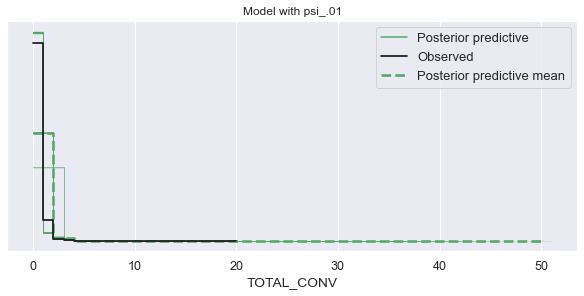

R2 for Model with psi_.01 is : 0.032


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


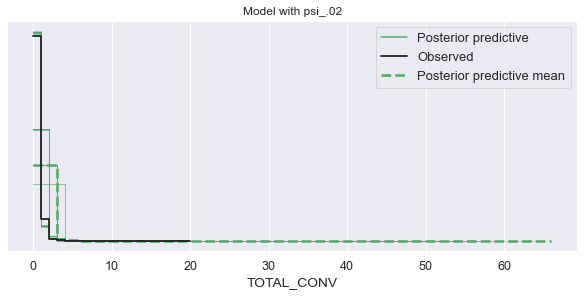

R2 for Model with psi_.02 is : 0.178


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


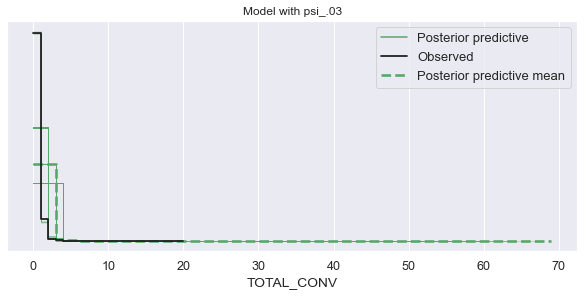

R2 for Model with psi_.03 is : 0.446


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


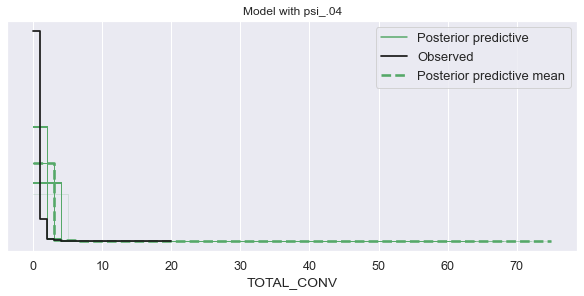

R2 for Model with psi_.04 is : 0.642


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


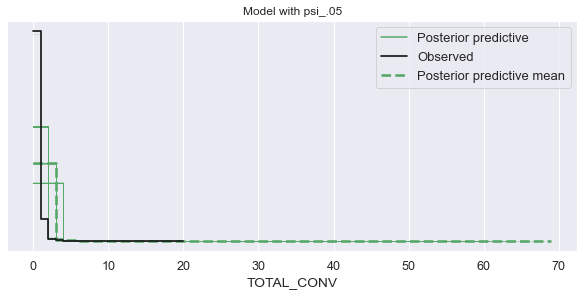

R2 for Model with psi_.05 is : 0.744


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


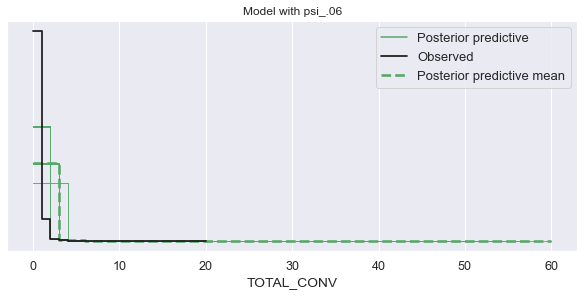

R2 for Model with psi_.06 is : 0.806


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


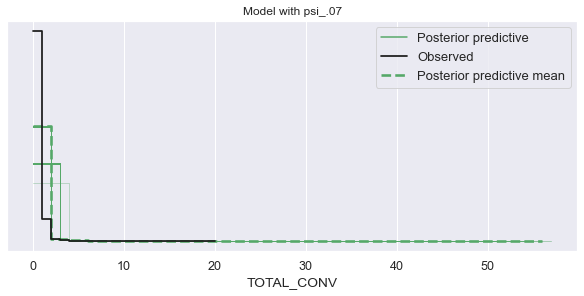

R2 for Model with psi_.07 is : 0.826


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


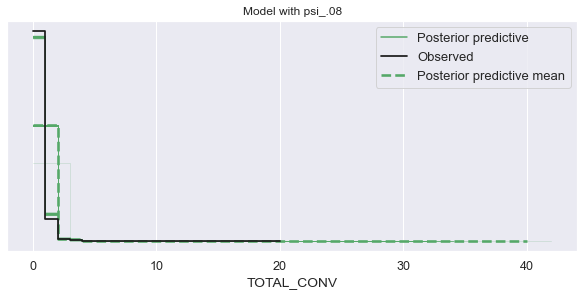

R2 for Model with psi_.08 is : 0.447


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


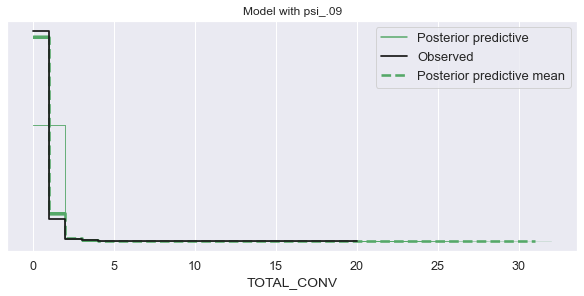

R2 for Model with psi_.09 is : 0.333


In [42]:
for v in model_trace_list:
    r2 =ppc_check(model=v[0], trace=v[1])

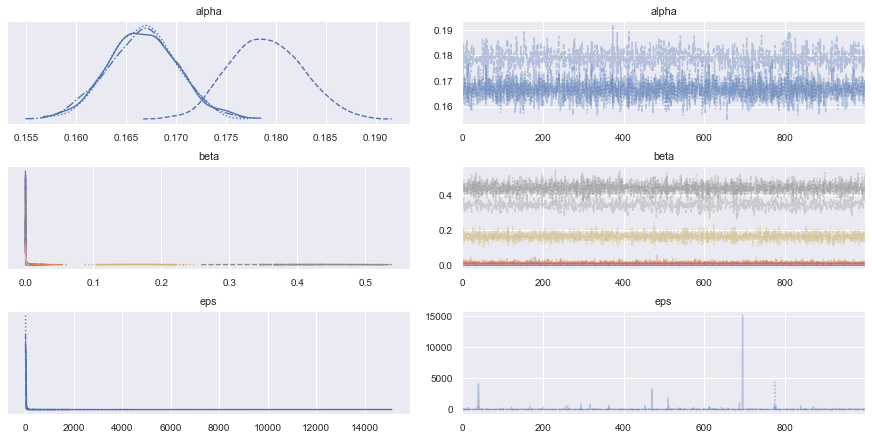

In [55]:
az.plot_trace(individual_traces['trace_psi_0.7'])
plt.show()

In [50]:
# az.summary(individual_traces['trace_psi_0.7'], var_names='beta')

In [51]:
az.summary(individual_traces['trace_psi_0.7'],
           var_names = 'beta'
          ).set_index(data[[col for col in data.columns if col != 'TOTAL_CONV']].columns)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
TV_ANE                     0.000  0.000   0.000    0.001      0.000    0.000   
TV_AMC                     0.001  0.001   0.000    0.001      0.000    0.000   
TV_ANIMALPLANET            0.000  0.000   0.000    0.001      0.000    0.000   
TV_BBCAMERICA              0.004  0.004   0.000    0.012      0.000    0.000   
TV_BET                     0.000  0.000   0.000    0.000      0.000    0.000   
TV_BETHER                  0.004  0.004   0.000    0.011      0.000    0.000   
TV_BRAVO                   0.000  0.000   0.000    0.001      0.000    0.000   
TV_COMEDYCENTRAL           0.001  0.001   0.000    0.002      0.000    0.000   
TV_COUNTRYMUSICTELEVISION  0.000  0.000   0.000    0.001      0.000    0.000   
TV_FOODNETWORK             0.000  0.000   0.000    0.001      0.000    0.000   
TV_GAMESHOWNETWORK         0.000  0.000   0.000    0.001      0.000    0.000   
TV_IFC                     0.005  0.004   0.000    0.013      0.000    0.000   
TV_INVESTIGATIONDISCOVERY  0.000  0.000   0.000    0.001      0.000    0.000   
TV_LIFETIME                0.000  0.000   0.000    0.001      0.000    0.000   
TV_LIFETIMEMOVIES          0.000  0.000   0.000    0.001      0.000    0.000   
TV_OPRAHWINFREYNETWORK     0.001  0.001   0.000    0.002      0.000    0.000   
TV_OTHER                   0.000  0.000   0.000    0.001      0.000    0.000   
TV_OVATIONTV               0.001  0.001   0.000    0.002      0.000    0.000   
TV_PARAMOUNTNETWORK        0.000  0.000   0.000    0.000      0.000    0.000   
TV_POP                     0.000  0.000   0.000    0.001      0.000    0.000   
TV_SMITHSONIANNETWORK      0.002  0.002   0.000    0.006      0.000    0.000   
TV_SYFY                    0.006  0.006   0.000    0.017      0.000    0.000   
TV_TRUTV                   0.001  0.001   0.000    0.004      0.000    0.000   
TV_TVONE                   0.001  0.001   0.000    0.002      0.000    0.000   
TV_USANETWORK              0.000  0.000   0.000    0.000      0.000    0.000   
TV_VH1                     0.000  0.000   0.000    0.001      0.000    0.000   
TV_WETV                    0.001  0.001   0.000    0.001      0.000    0.000   
DIGITAL_HX                 0.414  0.050   0.314    0.489      0.021    0.016   
DIGITAL_TREMOR             0.120  0.071   0.000    0.188      0.035    0.026   

                           ess_bulk  ess_tail  r_hat  
TV_ANE                       3835.0    2128.0   1.00  
TV_AMC                       4333.0    1953.0   1.00  
TV_ANIMALPLANET              4298.0    1991.0   1.00  
TV_BBCAMERICA                4207.0    1809.0   1.00  
TV_BET                       4490.0    1609.0   1.00  
TV_BETHER                    4580.0    2365.0   1.00  
TV_BRAVO                     4566.0    2418.0   1.00  
TV_COMEDYCENTRAL             4530.0    2101.0   1.00  
TV_COUNTRYMUSICTELEVISION    3965.0    2100.0   1.00  
TV_FOODNETWORK               4082.0    2103.0   1.00  
TV_GAMESHOWNETWORK           3954.0    1790.0   1.00  
TV_IFC                       3831.0    2114.0   1.00  
TV_INVESTIGATIONDISCOVERY    3255.0    1882.0   1.00  
TV_LIFETIME                  4468.0    2558.0   1.00  
TV_LIFETIMEMOVIES            3597.0    1934.0   1.00  
TV_OPRAHWINFREYNETWORK       4126.0    2117.0   1.00  
TV_OTHER                     3907.0    1954.0   1.00  
TV_OVATIONTV                 3557.0    1772.0   1.00  
TV_PARAMOUNTNETWORK          4231.0    1961.0   1.00  
TV_POP                       3618.0    1967.0   1.00  
TV_SMITHSONIANNETWORK        4124.0    2154.0   1.00  
TV_SYFY                      4293.0    2013.0   1.00  
TV_TRUTV                     4270.0    2311.0   1.00  
TV_TVONE                     3679.0    1943.0   1.00  
TV_USANETWORK                3935.0    2020.0   1.00  
TV_VH1                       3676.0    1871.0   1.00  
TV_WETV                      4155.0    2272.0   1.00  
DIGITAL_HX                      7.0      30.0   1.50  
DIGITAL_TREMOR                  

In [61]:
samples_zero = ppc_check(model_trace_list[6][0],model_trace_list[6][1], plot_ppc=False)

posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


R2 for Model with psi_.07 is : 0.827


In [74]:
samples_zero['conversion']

array([[0, 0, 7, ..., 0, 0, 0],
       [0, 0, 6, ..., 0, 0, 0],
       [1, 0, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 7, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### Using GLM Module and Normal for likelihood

In [86]:
# specifying priors and formula
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

d_coef = {}
for val in data.columns[:-1]:
    d_coef[val] = d_coef.get(val, pm.HalfNormal.dist())

d_intercept = {'Intercept': pm.Normal.dist()}

# combining priors
d_priors = {**d_intercept,**d_coef}

In [88]:
# Context for the model
with pm.Model() as model_glm_normal:
    family = pm.glm.families.StudentT()
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula,
                        data = data, 
                        priors = d_priors)
    
    trace_glm_normal = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, DIGITAL_TREMOR, DIGITAL_HX, TV_WETV, TV_VH1, TV_USANETWORK, TV_TVONE, TV_TRUTV, TV_SYFY, TV_SMITHSONIANNETWORK, TV_POP, TV_PARAMOUNTNETWORK, TV_OVATIONTV, TV_OTHER, TV_OPRAHWINFREYNETWORK, TV_LIFETIMEMOVIES, TV_LIFETIME, TV_INVESTIGATIONDISCOVERY, TV_IFC, TV_GAMESHOWNETWORK, TV_FOODNETWORK, TV_COUNTRYMUSICTELEVISION, TV_COMEDYCENTRAL, TV_BRAVO, TV_BETHER, TV_BET, TV_BBCAMERICA, TV_ANIMALPLANET, TV_AMC, TV_ANE, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1185 seconds.


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


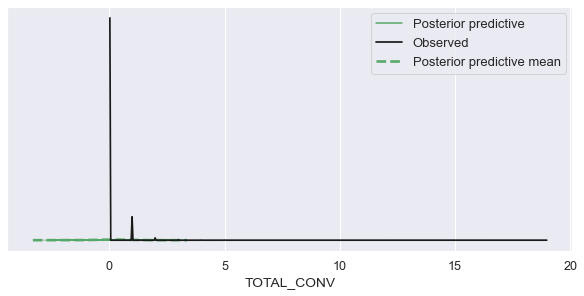

R2 for Model is : 0.006


In [99]:
samples_normal = ppc_check(model=model_glm_normal,
                           trace=trace_glm_normal , 
                           glm=True)

### Model with StudentT for likelihood

In [100]:
# specifying priors and formula
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

d_coef = {}
for val in data.columns[:-1]:
    d_coef[val] = d_coef.get(val, pm.HalfFlat.dist())

d_intercept = {'Intercept': pm.Normal.dist()}

# combining priors
d_priors = {**d_intercept,**d_coef}

In [111]:
# Context for the model
with pm.Model() as model_student:
    
    alpha = pm.Normal('alpha', mu= y.mean(), sd = 1)
    beta = pm.HalfNormal('beta', sd = 40, shape = len(data.columns[:-1]))
    eps = pm.HalfNormal('eps', 5)
    v_ = pm.Exponential('v_', 1/29)
    v = pm.Deterministic('v', v_+1)
    
    mu = alpha + pm.math.dot(x,beta)
    
    convergence = pm.StudentT('convergence', mu= mu, nu= v, sd= eps, observed = y)
    
    trace_glm_student = pm.sample(chains = 4, target_accept = 0.96)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [v_, eps, beta, alpha]


KeyError: 0